# Using the calf package

The calf package includes a `main()` function, which is the main way to execute it.

We start by doing some preparation:

- Create a datacube client
- Load the region of interest and crop mask

In [1]:
import logging
import os
from pathlib import Path


import datacube
import geopandas
import ipywidgets as widgets
import numpy as np
import rasterio.windows
import rioxarray
import xarray as xr
from IPython.display import display

import calf

# this is a minor detail, toning down third-party loggers
logging.basicConfig(level=logging.INFO)
for logger_name in ("datacube", "fiona", "matplotlib", "pyproj", "rasterio"):
    logging.getLogger(logger_name).setLevel(logging.WARNING)


dc = datacube.Datacube(
    app="test-calf",
    env="sandbox",
    config=os.getenv("DATACUBE_CONFIG_PATH")
)

roi_gdf = geopandas.read_file(Path("../test-data/auxiliary.gpkg"), layer="region-of-interest")
crop_gdf = geopandas.read_file(Path("../test-data/auxiliary.gpkg", layer="crop-mask"))

output_resolution=20
start_date = "2015-01-01"
end_date = "2021-12-31"

calf_result = calf.compute_calf(
    dc, 
    start_date=start_date,
    end_date=end_date,
    ard_product="test_spot7_gauteng_old_eo3",
    region_of_interest_gdf=roi_gdf,
    crop_mask_gdf=crop_gdf,
    vegetation_threshold=0.2,
    red_band="red",
    nir_band="nir",
    qflags_band="spclass",
    output_crs="EPSG:32635",
    output_resolution=output_resolution,
    return_patches=True
)

/datadisk/miniconda3/envs/sansa-crop-arable-land-fraction/lib/python3.8/site-packages/datacube/drivers/postgres/_connections.py:81: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  EngineUrl(
/datadisk/miniconda3/envs/sansa-crop-arable-land-fraction/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


The output of the function is an object of type `calf.CalfAlgorithmResult`. It contains the following properties:

- `calf_ds` - an `xarray.Dataset` that contains the final spatial layers generated by the CALF algorithm
- `calf_stats` - a `pandas.DataFrame` that contains the statistics gathered during calculation
- `patches` - a list with the individual raster patches that were processed. **NOTE** - In order to have this list be populated with the actual patches, you must provide `return_patches=True` as a parameter to the calf algorithm. Otherwise it will be an empty list. This should be used for debug purposes only, as it increases the algorithm's memory consumption

## calf_ds

the output `calf_ds` is an `xarray.Dataset` that contains the CALF spatial layers. The following are included:

- `calf` - This is the final CALF product, reclassified
- `raw_calf` - This is the non-reclassified CALF product
- `seasonal_ndvi` - This is the aggregated NDVI that served as an input for computing CALF

In [2]:
calf_result.calf_ds

<xarray.Dataset>
Dimensions:        (x: 147, y: 73)
Coordinates:
  * x              (x) float64 6.191e+05 6.191e+05 ... 6.22e+05 6.22e+05
  * y              (y) float64 -2.976e+06 -2.976e+06 ... -2.977e+06 -2.977e+06
    spatial_ref    int64 0
Data variables:
    seasonal_ndvi  (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    raw_calf       (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    calf           (y, x) uint8 100 100 100 100 100 100 ... 100 100 100 100 100

### calf

This data array contains the final CALF values

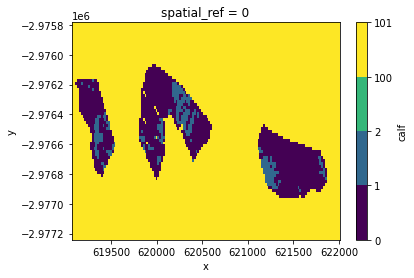

In [3]:
calf_result.calf_ds.calf.plot(levels=[0, 1, 2, 100, 101])

### raw_calf

This data array contains the un reclassified CALF values

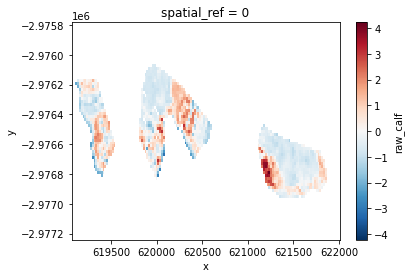

In [4]:
calf_result.calf_ds.raw_calf.plot()

### seasonal_ndvi

This data array contains the aggregated NDVI

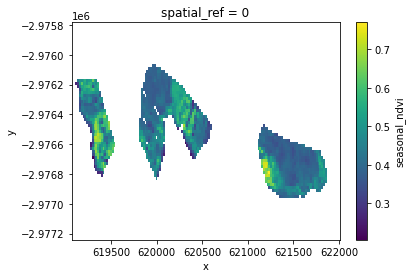

In [5]:
calf_result.calf_ds.seasonal_ndvi.plot()

## calf_stats

This is a `pandas.DataFrame` that contains the statistic values gathered when running the algorithm

In [6]:
calf_result.calf_stats

,region_of_interest,crop_mask,fallow_pixels,planted_pixels,calf_pixels
0,municipality1,parcel1,77,11,88
1,municipality1,parcel2,94,18,112
2,municipality1,parcel3,51,9,60
3,municipality1,parcel5,406,113,519
4,municipality1,parcel6,542,84,626
5,municipality2,parcel4,303,68,371


## Saving results

In order to save results to disk you can use the following auxiliary functions:

In [2]:
stats_output_path = Path(f"../results/calf_stats_{start_date}-{end_date}_{output_resolution}m.csv")
calf_tiff_output_path = Path(f"../results/calf_{start_date}-{end_date}_{output_resolution}m.tif")
calf_aux_tiff_output_path = Path(f"../results/calf-aux_{start_date}-{end_date}_{output_resolution}m.tif")


calf.save_calf_result(calf_result.calf_ds, calf_tiff_output_path)
calf.save_aux_calf_result(calf_result.calf_ds, calf_aux_tiff_output_path)

calf_result.calf_stats.to_csv(stats_output_path, index=False)